<a href="https://colab.research.google.com/github/alviyandriadillah/Machine-Learning/blob/main/4_5_Weight_Decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mxnet

In [2]:
pip install d2l

**4.5.2. High-Dimensional Linear Regression**

In [3]:
%matplotlib inline
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

In [4]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = np.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

**4.5.3.1. Initializing Model Parameters**

In [5]:
def init_params():
    w = np.random.normal(scale=1, size=(num_inputs, 1))
    b = np.zeros(1)
    w.attach_grad()
    b.attach_grad()
    return [w, b]

**4.5.3.2. Defining  L2  Norm Penalty**

In [6]:
def l2_penalty(w):
    return (w**2).sum() / 2

**4.5.3.3. Defining the Training Loop**

In [7]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # The L2 norm penalty term has been added, and broadcasting
                # makes `l2_penalty(w)` a vector whose length is `batch_size`
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', np.linalg.norm(w))

**4.5.3.4. Training without Regularization**

In [8]:
pip uninstall matplotlib

Found existing installation: matplotlib 3.3.3
Uninstalling matplotlib-3.3.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.3.3


In [9]:
pip install matplotlib

     |████████████████████████████████| 11.2 MB 8.5 MB/s 
     |████████████████████████████████| 890 kB 52.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 3.5.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


L2 norm of w: 13.259392


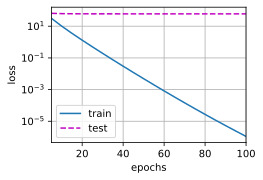

In [10]:
train(lambd=0)

**4.5.3.5. Using Weight Decay**

L2 norm of w: 0.38247848


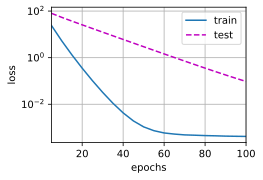

In [11]:
train(lambd=3)

**4.5.4. Concise Implementation**

In [12]:
def train_concise(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    loss = gluon.loss.L2Loss()
    num_epochs, lr = 100, 0.003
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr, 'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias"
    net.collect_params('.*bias').setattr('wd_mult', 0)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', np.linalg.norm(net[0].weight.data()))

L2 norm of w: 15.014068


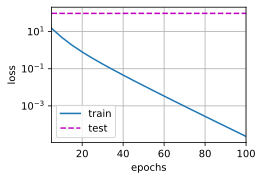

In [13]:
train_concise(0)

L2 norm of w: 0.33993044


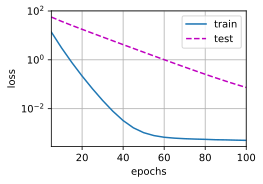

In [14]:
train_concise(3)